In [20]:
# All util functions

import os
import random
import math
from torchvision.io.image import decode_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection import fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import torch
import onnxruntime as ort
import numpy as np 
from tqdm import tqdm
import logging
import cv2 



def batched(array, size):
    array_iter = iter(array) 
    while True: 
        b = []
        try: [b.append(next(array_iter)) for _ in range(size)]
        except: StopIteration
        if b: yield b 
        else: break

def annotate(img, prediction, categories):
    labels = [categories[i] for i in prediction["labels"]]
    boxes = prediction['boxes']
    box = draw_bounding_boxes(
        image=img, 
        boxes=boxes, 
        labels=labels, 
        colors="red", 
        width=4, 
        font="Helvetica.ttf" if os.path.exists("Helvetica.ttf") else None, 
        font_size=30
    )
    im = to_pil_image(box.detach())
    return im

def annotate_batch(images, predictions, categories, thresh=0.5): 
    annotated_images = [] 
    for image, prediction in zip(images, predictions): 
        prediction = {
            k: prediction[k][prediction['scores']>thresh] for k in prediction
        }
        annotated_images.append(annotate(image, prediction, categories)) 
    return annotated_images

def filter_prediction(prediction, thresh=0.5): 
    if not isinstance(prediction, dict):
        return [filter_predictions(pred, thresh) for pred in predictions]
    return {
        k: prediction[k][prediction['scores']>thresh] for k in prediction
    }


class ONNX_model: 
    def __init__(self, model_file): 
        self.session = ort.InferenceSession(model_file, provider_options=ort.get_available_providers()) # from https://onnxruntime.ai/docs/api/python/tutorial.html
    def infer(self, input_img): 
        input_img = np.asarray(input_img)
        input_img = input_img.reshape(1, *input_img.shape)
        input_name = self.session.get_inputs()[0].name
        output_names = [out.name for out in self.session.get_outputs()] 
        outputs = self.session.run(output_names, {input_name: input_img}) 
        return { 
            name: torch.from_numpy(op) for name, op in zip(output_names, outputs) 
        }
    def __call__(self, input_batch):
        return [self.infer(img) for img in input_batch] 


def get_model_and_weights(builder_func=fcos_resnet50_fpn, weight_class=FCOS_ResNet50_FPN_Weights, get_onnx=False): 
    logger = logging.getLogger("model_and_weights")
    weights = weight_class.DEFAULT
    if not get_onnx: 
        model = builder_func(weights=weights, box_score_thresh=0.9)
        model.eval()
        return model, weights
    else: 
        model_file = str(weights.DEFAULT)+'.onnx' 
        if os.path.exists(model_file): 
            model = ONNX_model(model_file) 
            return model, weights 
        else: 
            logger.info(f"{model_file} not found, exporting pytorch model to {model_file}") 
            model, _ = get_model_and_weights(builder_func, weight_class, get_onnx=False) 
            dummy_input = torch.randn(1, 3, 1000,1000)
            torch.onnx.export(
                model,
                dummy_input,
                model_file,
                export_params=True,
                opset_version=11,
                do_constant_folding=True,
                input_names=['input'],
                output_names=list(model(dummy_input)[0].keys()) ,
                dynamic_axes={
                    'input': {0: 'batch_size', 2: 'height', 3: 'width'},  # Make batch, height, and width dynamic
                    'output': {0: 'batch_size'}  # Example: make output batch dimension dynamic
                }
            )
            return get_model_and_weights(builder_func, weight_class, get_onnx=True) 
            

def detection2D(files, output_dir='output', batch_size=5, builder_and_weights=(fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights), use_onnx=False):
    logger = logging.getLogger("detection2D")
    if not os.path.isdir(output_dir): 
        logger.warning(f"Output directory '{output_dir}' was not found. Creating directory '{output_dir}'")
        os.mkdir(output_dir)
    fnames = [os.path.basename(f) for f in files]
    save_files = [os.path.join(output_dir, p) for p in fnames]
    imgs = [(decode_image(f), sf) for f, sf in zip(files, save_files)]
    batches = batched(imgs, batch_size) 
    batches = (tuple(zip(*b)) for b in batches)
    
    logger.info("Loading model")
    model, weights = get_model_and_weights(*builder_and_weights, use_onnx)
    preprocess = weights.transforms()
    def infer(images):
        processed_images = [preprocess(img) for img in images] 
        return model(processed_images) 

    logger.info("Starting detection")
    for batch in tqdm(batches, total=math.ceil(len(imgs)/batch_size)):
        images, save_names = batch
        predictions = infer(images) 
        
        # detect_annotate_save(images, save_names, preprocess, model, weights.meta["categories"]) 
        annotated_images = annotate_batch(images, predictions, weights.meta['categories']) 
        [img.save(sn) for img, sn in zip(annotated_images, save_names)]

def get_infer_method(model, preproc):
    def infer(imgs): 
        proced = [preproc(img) for img in imgs] 
        return model(proced) 
    return infer
def cv2torch(frame): 
    return torch.from_numpy(
        np.transpose(
            cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 
            (2,0,1) 
        )
    )
def pil2cv2(img): 
    return cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
def frame_generator(cap): 
    ret, frame = cap.read()
    while ret: 
        yield frame
        ret, frame = cap.read()

def video_detection2d(video_path, output_path, batch_size=2, use_onnx=True):
    logger = logging.getLogger("video_detection2d")
    output_dir = os.path.dirname(output_path) 
    if not os.path.isdir(output_dir): 
        logger.info(f"output dir {output_dir} not found. Creating output dir {output_dir}") 
        os.mkdir(output_dir) 
        
    cap = cv2.VideoCapture(video_path) 
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT) 
    # print(cap.get(cv2.CAP_PROP_FRAME_WIDTH),cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

    model, weights = get_model_and_weights(fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights, get_onnx=use_onnx) 
    infer = get_infer_method(model, weights.transforms())
    
    batched_frames = batched(frame_generator(cap), batch_size)
    for i, batch in enumerate(tqdm(batched_frames, total=math.ceil(frame_count/batch_size))): 
        # batch = next(iter(batched_frames))
        if i%3==0: continue
        try: 
            imgs = [cv2torch(img) for img in batch] 
            preds = infer(imgs) 
            annotated_batch = annotate_batch(imgs, preds, weights.meta['categories'])
            out_frames = [pil2cv2(img) for img in annotated_batch]  
            for frame in out_frames: out.write(frame) 
        except KeyboardInterrupt: 
            break
        
    
    cap.release()
    out.release()


# Detection on 2d images

The following is a time analysis demo of detection on multiple different stock photos. This photos vary in size, aspect ration, contents and more.

We will compare the time taken to detect and annotate all images by 2 different models on 2 different runtimes for a total of 4 different cases

**Models**
- [FasterRCNN with a resnet50+fpn for a backbone](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn_v2.html#torchvision.models.detection.fasterrcnn_resnet50_fpn_v2)
- [FCOS with a resnet50+fpn for a backbone](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fcos_resnet50_fpn.html#torchvision.models.detection.FCOS_ResNet50_FPN_Weights)

**Runtimes**
- Pytorch
- ONNX runtime (python)

In [4]:
files = [os.path.join("pics", f) for f in os.listdir("pics")] 

In [6]:
import time

# FRCNN_torch 
print("Timing FRCNN_torch")
frcnn_torch = time.time()
detection2D(files,output_dir="frcnn_torch",batch_size=3, builder_and_weights=(fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights), use_onnx=False) 
frcnn_torch = time.time()-frcnn_torch
print(f"{frcnn_torch//60}:{frcnn_torch%60} minutes")
# FRCNN_ONNX
print("Timing FRCNN_ONNX")
frcnn_onnx = time.time()
detection2D(files,output_dir="frcnn_onnx",batch_size=3, builder_and_weights=(fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights), use_onnx=True) 
frcnn_onnx = time.time()-frcnn_onnx
print(f"{frcnn_onnx//60}:{frcnn_onnx%60} minutes")
# FCOS_torch
print("Timing FCOS_torch")
fcos_torch = time.time()
detection2D(files,output_dir="fcos_torch",batch_size=3, builder_and_weights=(fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights), use_onnx=False) 
fcos_torch = time.time()-fcos_torch
print(f"{fcos_torch//60}:{fcos_torch%60} minutes")
# FCOS_ONNX
print("Timing FCOS_ONNX")
fcos_onnx = time.time()
detection2D(files,output_dir="fcos_onnx",batch_size=3, builder_and_weights=(fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights), use_onnx=True) 
fcos_onnx = time.time()-fcos_onnx
print(f"{fcos_onnx//60}:{fcos_onnx%60} minutes")


Output directory 'frcnn_torch' was not found. Creating directory 'frcnn_torch'


Timing FRCNN_torch


  0%|                                                                                                                                      | 0/16 [00:00<?, ?it/s]/home/raka/Projects/InferenceOptimization/.env6/lib/python3.10/site-packages/torchvision/utils.py:211: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [11:28<00:00, 43.00s/it]
Output directory 'frcnn_onnx' was not found. Creating directory 'frcnn_onnx'


11.0:35.27180624008179 minutes
Timing FRCNN_ONNX


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:09<00:00, 11.84s/it]
Output directory 'fcos_torch' was not found. Creating directory 'fcos_torch'


3.0:49.718024015426636 minutes
Timing FCOS_torch


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [05:07<00:00, 19.21s/it]
Output directory 'fcos_onnx' was not found. Creating directory 'fcos_onnx'


5.0:19.517751693725586 minutes
Timing FCOS_ONNX


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:14<00:00,  8.41s/it]


2.0:31.388925790786743 minutes


23 min to run all tests

Text(0.5, 1.0, 'execution time')

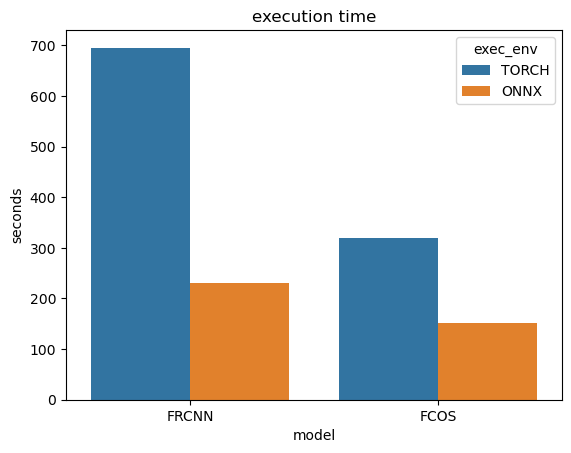

In [18]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

df = pd.DataFrame({
    "seconds": [frcnn_torch, frcnn_onnx, fcos_torch, fcos_onnx], 
    "model": ["FRCNN","FRCNN","FCOS","FCOS",], 
    "exec_env": ["TORCH", "ONNX","TORCH", "ONNX"]
})
sns.barplot(df, y='seconds', x='model', hue='exec_env')
plt.title("execution time")

# Detection on video

The following is a time analysis demo of detection on an mp4 file

We will compare the performance of FCOS on torch vs onnx

In [22]:
# FCOS_ONNX
print("Timing FCOS_ONNX")
vfcos_onnx = time.time()
video_detection2d("vids/2048206-hd_1920_1080_30fps.mp4", "vids/FCOS_ONNX.mp4", use_onnx=True)
vfcos_onnx = time.time()-vfcos_onnx
print(f"{vfcos_onnx//60}:{vfcos_onnx%60} minutes")
# FCOS_torch
print("Timing FCOS_torch")
vfcos_torch = time.time()
video_detection2d("vids/2048206-hd_1920_1080_30fps.mp4", "vids/FCOS_TORCH.mp4", use_onnx=False)
vfcos_torch = time.time()-vfcos_torch
print(f"{vfcos_torch//60}:{vfcos_torch%60} minutes")


Timing FCOS_ONNX


 69%|████████████████████████████████████████████████████████████████████████████████████▉                                      | 259/375 [09:24<04:12,  2.18s/it]


9.0:24.45399260520935 minutes
Timing FCOS_torch


  0%|▎                                                                                                                            | 1/375 [00:00<02:49,  2.20it/s]

0.0:1.1578750610351562 minutes
